<a href="https://colab.research.google.com/github/esb-index/Barka-AV/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p /content/era5_processed_light && mv /content/*_daily_light.csv /content/era5_processed_light/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os

# --- 1️⃣ Beállítások ---
input_dir = "/content/cpri_outputs"
daily_file = f"{input_dir}/dania_daily_merged.csv"
assets_file = f"{input_dir}/assets.xlsx"

hazards = {
    "flood": "tp_sum_mean",
    "windstorm": ["u10_max_mean", "v10_max_mean"],
    "heatwave": "t2m_mean_mean",
    "coldwave": "t2m_mean_mean",
    "solar_anomaly": "ssrd_mean_mean",
    "snow": "sd_mean_mean",
}

region_weight = 0.8  # Dánia
maintenance_default = 0.7
year_target = range(2000, 2025)

# --- 2️⃣ Adatok betöltése ---
df = pd.read_csv(daily_file)
assets = pd.read_excel(assets_file)

# Csak Dánia eszközei
assets = assets[assets['country'].str.lower().str.contains("denmark")]

# Dátum formázás és év oszlop
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- 3️⃣ MICE imputálás (hiányzó napi adatokra) ---
imp = IterativeImputer(max_iter=10, random_state=42)
num_cols = [c for c in df.columns if c not in ["date", "year"]]
df[num_cols] = imp.fit_transform(df[num_cols])


# --- 4️⃣ Hazard számítás (javított) ---
hazard_results = []

for hz, cols in hazards.items():
    df_h = df.copy()

    if isinstance(cols, list):
        df_h["hazard_value"] = np.sqrt(df_h[cols[0]]**2 + df_h[cols[1]]**2)
    else:
        df_h["hazard_value"] = df_h[cols]

    # Éves aggregálás
    df_y = df_h.groupby("year", as_index=False).agg({
        "hazard_value": ["mean", "max", "count"]
    })
    df_y.columns = ["year", "mean", "max", "count"]

    # Percentilis-küszöbök
    p95 = df_h["hazard_value"].quantile(0.95)
    p05 = df_h["hazard_value"].quantile(0.05)

    # Számoljuk év szerint a szélsőségek arányát
    exceed = (df_h["hazard_value"] > p95).groupby(df_h["year"]).sum().reset_index()
    cold = (df_h["hazard_value"] < p05).groupby(df_h["year"]).sum().reset_index()
    total = df_h.groupby("year")["hazard_value"].count().reset_index()

    exceed.columns = ["year", "exceed_count"]
    cold.columns = ["year", "cold_count"]
    total.columns = ["year", "total_days"]

    df_y = df_y.merge(exceed, on="year", how="left").merge(cold, on="year", how="left").merge(total, on="year", how="left")

    df_y["exceed_count"] = df_y["exceed_count"].fillna(0)
    df_y["cold_count"] = df_y["cold_count"].fillna(0)

    if hz == "coldwave":
        df_y["P_norm"] = df_y["cold_count"] / df_y["total_days"]
    else:
        df_y["P_norm"] = df_y["exceed_count"] / df_y["total_days"]

    # H_norm és E kiszámítása
    df_y["H_norm"] = (df_y["max"] - df_y["mean"]) / (df_y["max"].max() - df_y["mean"].min() + 1e-6)
    df_y["hazard"] = hz
    df_y["region"] = "dania"
    df_y["E"] = (df_y["H_norm"] + df_y["P_norm"]**2) * region_weight

    hazard_results.append(df_y)

# --- 5️⃣ Vulnerability (V) ---
def get_V0(row):
    type_map = {
        ("wind", "offshore"): 0.6, ("wind", "onshore"): 0.4,
        ("solar", "pv"): 0.3, ("hydro", "-"): 0.5,
        ("biomass", "-"): 0.4, ("gas", "-"): 0.7,
        ("coal", "-"): 0.7, ("nuclear", "-"): 0.8,
        ("hydrogen", "-"): 0.9, ("storage", "battery"): 0.7,
        ("grid", "transmission"): 0.6
    }
    return type_map.get((str(row["type"]).lower(), str(row["subtype"]).lower()), 0.5)

assets["V0"] = assets.apply(get_V0, axis=1)
assets["age_factor"] = 2025 - assets["commission_year"]
assets["maintenance"] = maintenance_default
assets["V"] = np.clip(
    assets["V0"] * (1 + 0.3 * assets["age_factor"] / 50) * (1 - 0.4 * assets["maintenance"]),
    0, 1
)
# --- 6️⃣ Hazard táblák egyesítése ---
hazard_all = pd.concat(hazard_results, ignore_index=True)

# --- 6️⃣ Risk számítás ---
r_values = []
for _, a in assets.iterrows():
    for _, hz in hazard_all.iterrows():
        r = hz["H_norm"] * hz["P_norm"] * hz["E"] * a["V"]
        r_values.append({
            "asset_id": a["asset_id"],
            "asset_name": a["name"],
            "year": hz["year"],
            "hazard": hz["hazard"],
            "H_norm": hz["H_norm"],
            "P_norm": hz["P_norm"],
            "E": hz["E"],
            "V": a["V"],
            "r": r
        })

r_df = pd.DataFrame(r_values)

# --- 7️⃣ Mentés ---
os.makedirs(input_dir, exist_ok=True)
hazard_all.to_csv(f"{input_dir}/exposure_matrix_dania.csv", index=False)
assets[["asset_id", "V0", "age_factor", "maintenance", "V"]].to_csv(f"{input_dir}/vulnerability_matrix_dania.csv", index=False)
r_df.to_csv(f"{input_dir}/r_values_dania.csv", index=False)

print(f"✅ Kész! {len(r_df)} sor mentve -> /content/cpri_outputs/r_values_dania.csv")
print(r_df.head(10))


✅ Kész! 1296 sor mentve -> /content/cpri_outputs/r_values_dania.csv
  asset_id   asset_name  year hazard    H_norm    P_norm         E         V  \
0   DK-001  Horns Rev 1  2000  flood  0.915138  0.046448  0.733837  0.491616   
1   DK-001  Horns Rev 1  2001  flood  0.773694  0.046575  0.620690  0.491616   
2   DK-001  Horns Rev 1  2002  flood  0.957348  0.043836  0.767416  0.491616   
3   DK-001  Horns Rev 1  2003  flood  0.537256  0.038356  0.430982  0.491616   
4   DK-001  Horns Rev 1  2004  flood  0.764437  0.043716  0.613079  0.491616   
5   DK-001  Horns Rev 1  2005  flood  0.851069  0.032877  0.681720  0.491616   
6   DK-001  Horns Rev 1  2006  flood  0.766058  0.057534  0.615494  0.491616   
7   DK-001  Horns Rev 1  2007  flood  0.931599  0.052055  0.747447  0.491616   
8   DK-001  Horns Rev 1  2008  flood  0.655536  0.043716  0.525957  0.491616   
9   DK-001  Horns Rev 1  2009  flood  0.987361  0.043836  0.791426  0.491616   

          r  
0  0.015335  
1  0.010996  
2  0.0158

Input rows: 1296 columns: ['asset_id', 'asset_name', 'year', 'hazard', 'H_norm', 'P_norm', 'E', 'V', 'r']
Unique asset-year-hazard combos: 1296
✅ Monte Carlo kész — mentve: /content/cpri_outputs/mc_results/mc_summary_dania.csv


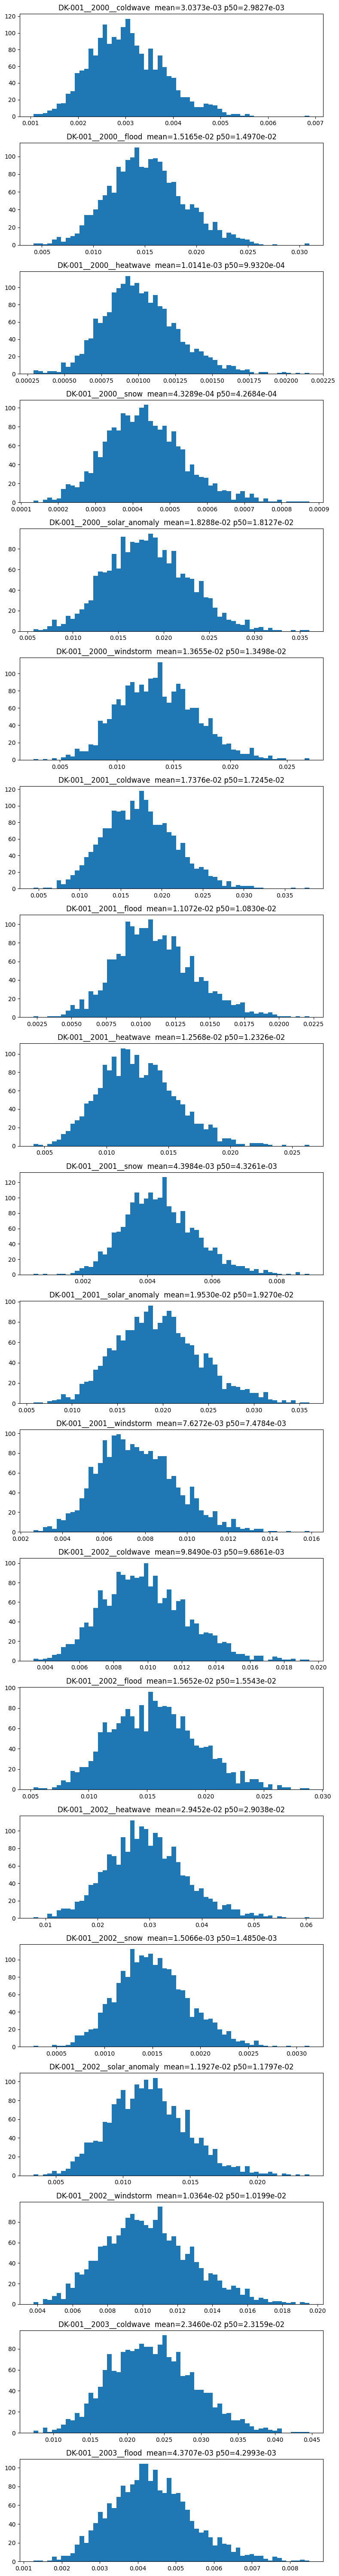

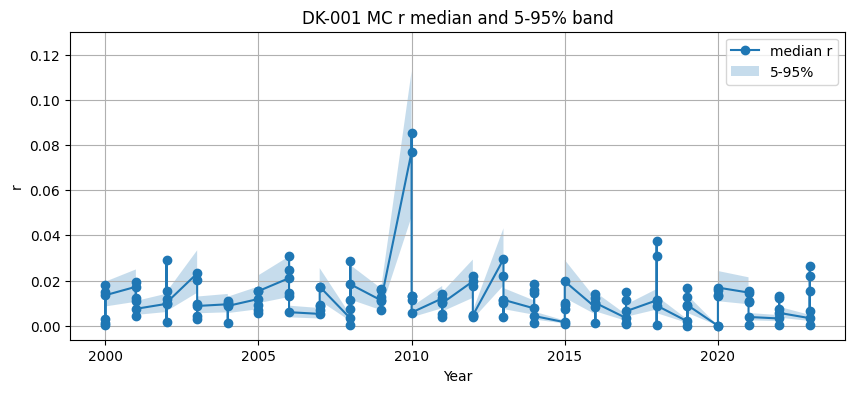


Próbáljuk Sobol analízist az első combo-ra: ('DK-001', np.int64(2000), 'coldwave')
SALib nem elérhető. Telepítsd: `pip install SALib` ha Sobol-t akarsz futtatni.

Kész. MC summary elérhető itt: /content/cpri_outputs/mc_results/mc_summary_dania.csv


In [ ]:
# Monte Carlo + (opcionális) Sobol érzékenységi elemzés
# Futtasd Colabban egy cellában.
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------- USER SETTINGS ----------
INPUT_CSV = "/content/cpri_outputs/r_values_dania.csv"   # v. r_values_enhanced.csv és szűrt 'dania'
OUTPUT_DIR = "/content/cpri_outputs/mc_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MC_SAMPLES = 2000           # alap, javasolt >=2000 (nagyobb jobb)
RANDOM_SEED = 42

# Alap feltételezések a bizonytalanságokra (relatív std, azaz sd = rel * value)
# Ezeket tetszés szerint állítsd. Ha value közel 0 -> használunk abszolút kis sd-t.
UNCERTAINTY = {
    "H_rel_sd": 0.10,      # H_norm relatív szórása (10%)
    "P_rel_sd": 0.20,      # P_norm relatív szórása (20%) -- gyakoriság nagyobb bizonytalanság
    "E_rel_sd": 0.05,      # Exposure region weight bizonytalanság (5%)
    "V_rel_sd": 0.10       # Vulnerability bizonytalanság (10%)
}
# ---------- END SETTINGS ----------

np.random.seed(RANDOM_SEED)

# ---------- Helper functions ----------
def truncated_normal(mean, sd, low=0.0, high=1.0, size=1):
    """Egyszerű truncált normal: visszautasításos módszer (ok-ish a MC mérethez)."""
    if np.isnan(mean):
        return np.full(size, np.nan)
    # if mean is 0 and sd==0 return zeros
    if sd <= 0 or mean==0:
        return np.clip(np.full(size, mean), low, high)
    out = np.empty(size)
    i = 0
    # vectorized rejection sampling
    while i < size:
        # generate batch
        batch = np.random.normal(loc=mean, scale=sd, size=(size-i,))
        batch = np.clip(batch, low, high)
        out[i:i+len(batch)] = batch
        i += len(batch)
    return out

def safe_rel_sd_to_abs(val, rel_sd, min_abs=1e-6):
    """Ha val nagyon kicsi, ne legyen sd=0 --> használjunk min_abs"""
    if np.isnan(val):
        return np.nan
    sd = abs(val) * rel_sd
    return max(sd, min_abs)

# ---------- Load baseline table ----------
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"Input CSV nem található: {INPUT_CSV}")

df = pd.read_csv(INPUT_CSV)
print("Input rows:", len(df), "columns:", df.columns.tolist())

# Ensure columns exist
required = ["asset_id","year","hazard","H_norm","P_norm","E","V","r"]
for c in required:
    if c not in df.columns:
        raise KeyError(f"Hiányzó oszlop a bemenetben: {c}")

# We'll run MC per unique (asset_id, year, hazard)
groups = df.groupby(["asset_id","year","hazard"], as_index=False)
combos = [(aid, yr, hz) for aid, yr, hz in df[["asset_id","year","hazard"]].drop_duplicates().itertuples(index=False,name=None)]
print("Unique asset-year-hazard combos:", len(combos))

# Prepare output containers
mc_summary_rows = []   # summary per combo
mc_distributions = {}  # optionally save distribution arrays to disk by combo key (files)

# Run MC loop (progress bar)
for (asset_id, year, hazard), group in groups:
    # there should be single row per combo in our r_values_dania; but handle group anyway
    base = group.iloc[0]
    H0 = float(base["H_norm"]) if not np.isnan(base["H_norm"]) else np.nan
    P0 = float(base["P_norm"]) if not np.isnan(base["P_norm"]) else np.nan
    E0 = float(base["E"]) if not np.isnan(base["E"]) else np.nan
    V0 = float(base["V"]) if not np.isnan(base["V"]) else np.nan

    # If too many NaNs, skip or record NaN summary
    if np.isnan(H0) and np.isnan(P0):
        # no info
        mc_summary_rows.append({
            "asset_id": asset_id, "year": year, "hazard": hazard,
            "mc_n": 0, "r_mean": np.nan, "r_std": np.nan,
            "r_p5": np.nan, "r_p50": np.nan, "r_p95": np.nan,
            "nan_fraction": 1.0
        })
        continue

    # Determine absolute sd from relative
    H_sd = safe_rel_sd_to_abs(H0, UNCERTAINTY["H_rel_sd"])
    P_sd = safe_rel_sd_to_abs(P0, UNCERTAINTY["P_rel_sd"])
    E_sd = safe_rel_sd_to_abs(E0, UNCERTAINTY["E_rel_sd"])
    V_sd = safe_rel_sd_to_abs(V0, UNCERTAINTY["V_rel_sd"])

    # Sample
    n = MC_SAMPLES
    # H and P truncated in [0,1]
    H_samps = truncated_normal(H0, H_sd, 0.0, 1.0, n)
    P_samps = truncated_normal(P0, P_sd, 0.0, 1.0, n)
    # E and V could be >1? we clip to [0,1] because we interpret them as normalized
    E_samps = truncated_normal(E0, E_sd, 0.0, 1.0, n)
    V_samps = truncated_normal(V0, V_sd, 0.0, 1.0, n)

    # compute r for each sample: r = H * P * E * V
    r_samps = H_samps * P_samps * E_samps * V_samps

    # compute stats
    r_mean = np.nanmean(r_samps)
    r_std = np.nanstd(r_samps, ddof=1)
    r_p5 = np.nanpercentile(r_samps, 5)
    r_p50 = np.nanpercentile(r_samps, 50)
    r_p95 = np.nanpercentile(r_samps, 95)
    nan_fraction = np.isnan(r_samps).mean()

    mc_summary_rows.append({
        "asset_id": asset_id, "year": year, "hazard": hazard,
        "mc_n": n, "r_mean": r_mean, "r_std": r_std,
        "r_p5": r_p5, "r_p50": r_p50, "r_p95": r_p95,
        "nan_fraction": nan_fraction,
        "H0": H0, "P0": P0, "E0": E0, "V0": V0
    })

    # save distribution (optional - saves disk space as npz)
    key = f"{asset_id}__{year}__{hazard}"
    out_npz = os.path.join(OUTPUT_DIR, f"mc_{key}.npz")
    np.savez_compressed(out_npz, r=r_samps, H=H_samps, P=P_samps, E=E_samps, V=V_samps)
    mc_distributions[key] = out_npz

# Save summary to CSV
mc_summary = pd.DataFrame(mc_summary_rows)
mc_summary.to_csv(os.path.join(OUTPUT_DIR, "mc_summary_dania.csv"), index=False)
print("✅ Monte Carlo kész — mentve:", os.path.join(OUTPUT_DIR, "mc_summary_dania.csv"))

# ---------- Quick diagnostics & plots ----------
# 1) global histogram of all r samples concatenated (careful memory). Instead use sample of combos.
sample_keys = list(mc_distributions.keys())[:min(20, len(mc_distributions))]
if sample_keys:
    fig, axs = plt.subplots(len(sample_keys), 1, figsize=(8, 3*len(sample_keys)), tight_layout=True)
    if len(sample_keys)==1:
        axs = [axs]
    for ax, key in zip(axs, sample_keys):
        data = np.load(mc_distributions[key])["r"]
        ax.hist(data, bins=60)
        ax.set_title(key + f"  mean={np.nanmean(data):.4e} p50={np.nanpercentile(data,50):.4e}")
    plt.show()

# 2) time series of median +/- 5-95% for a chosen asset (take first asset)
first_asset = mc_summary['asset_id'].unique()[0]
sel = mc_summary[mc_summary['asset_id']==first_asset].sort_values('year')
if not sel.empty:
    years = sel['year']
    median = sel['r_p50']
    p5 = sel['r_p5']
    p95 = sel['r_p95']
    plt.figure(figsize=(10,4))
    plt.plot(years, median, marker='o', label='median r')
    plt.fill_between(years, p5, p95, alpha=0.25, label='5-95%')
    plt.title(f"{first_asset} MC r median and 5-95% band")
    plt.xlabel("Year"); plt.ylabel("r"); plt.legend(); plt.grid(True)
    plt.show()

# ---------- Optional: Sobol sensitivity (if SALib available) ----------
def try_sobol_for_combo(asset_id, year, hazard, nbase=1024):
    """
    Run Sobol indices for the given combo. Requires SALib (pip install SALib).
    We use parameters: H_norm, P_norm, E, V (all scaled 0..1)
    Returns dict with S1, ST
    """
    try:
        from SALib.sample import saltelli
        from SALib.analyze import sobol
    except Exception as e:
        print("SALib nem elérhető. Telepítsd: `pip install SALib` ha Sobol-t akarsz futtatni.")
        return None

    # load baseline distributions
    key = f"{asset_id}__{year}__{hazard}"
    if key not in mc_distributions:
        print("Nincs MC disztribúció ehhez a combo-hoz:", key)
        return None
    arr = np.load(mc_distributions[key])
    # We'll sample parameters uniformly from ranges [mean-2sd, mean+2sd] clipped to [0,1]
    H0, P0, E0, V0 = float(arr["H"][0]), float(arr["P"][0]), float(arr["E"][0]), float(arr["V"][0])
    H_sd = np.std(arr["H"]); P_sd = np.std(arr["P"]); E_sd = np.std(arr["E"]); V_sd = np.std(arr["V"])
    bounds = [
        [max(0, H0-2*H_sd), min(1, H0+2*H_sd)],
        [max(0, P0-2*P_sd), min(1, P0+2*P_sd)],
        [max(0, E0-2*E_sd), min(1, E0+2*E_sd)],
        [max(0, V0-2*V_sd), min(1, V0+2*V_sd)],
    ]
    problem = {
        'num_vars': 4,
        'names': ['H','P','E','V'],
        'bounds': bounds
    }
    # Saltelli sampling
    param_values = saltelli.sample(problem, nbase, calc_second_order=False)
    Y = np.empty(len(param_values))
    for i, row in enumerate(param_values):
        Hs, Ps, Es, Vs = row
        Y[i] = Hs * Ps * Es * Vs
    Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=False)
    return Si

# Example: try Sobol on first combo
if len(mc_summary)>0:
    ex0 = mc_summary.iloc[0]
    key_try = (ex0['asset_id'], ex0['year'], ex0['hazard'])
    print("\nPróbáljuk Sobol analízist az első combo-ra:", key_try)
    sobol_res = try_sobol_for_combo(*key_try)
    if sobol_res is not None:
        print("S1:", sobol_res['S1'])
        print("ST:", sobol_res['ST'])

# ---------- End ----------
print("\nKész. MC summary elérhető itt:", os.path.join(OUTPUT_DIR,"mc_summary_dania.csv"))


In [ ]:
import os, numpy as np, pandas as pd

INPUT_DIR = "/content/cpri_outputs/mc_results"
OUTPUT_CSV = "/content/cpri_outputs/mc_summary_dania.csv"

rows = []

for fname in sorted(os.listdir(INPUT_DIR)):
    if not fname.endswith(".npz"):
        continue
    path = os.path.join(INPUT_DIR, fname)
    parts = fname.replace(".npz","").split("__")
    if len(parts) != 3:  # pl. mc_DK-001__2000__flood.npz
        continue
    asset_id, year, hazard = parts
    year = int(year)
    data = np.load(path)
    r = data["r"]

    rows.append({
        "asset_id": asset_id,
        "year": year,
        "hazard": hazard,
        "r_mean": np.nanmean(r),
        "r_std": np.nanstd(r),
        "r_p5": np.nanpercentile(r,5),
        "r_p50": np.nanpercentile(r,50),
        "r_p95": np.nanpercentile(r,95)
    })

df = pd.DataFrame(rows)
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Összesítve {len(df)} kombináció -> {OUTPUT_CSV}")

print(df.head())


✅ Összesítve 1296 kombináció -> /content/cpri_outputs/mc_summary_dania.csv
    asset_id  year         hazard    r_mean     r_std      r_p5     r_p50  \
0  mc_DK-001  2000       coldwave  0.003037  0.000773  0.001890  0.002983   
1  mc_DK-001  2000          flood  0.015165  0.003718  0.009432  0.014970   
2  mc_DK-001  2000       heatwave  0.001014  0.000254  0.000641  0.000993   
3  mc_DK-001  2000           snow  0.000433  0.000109  0.000265  0.000427   
4  mc_DK-001  2000  solar_anomaly  0.018288  0.004515  0.011268  0.018127   

      r_p95  
0  0.004394  
1  0.021724  
2  0.001463  
3  0.000620  
4  0.025752  


In [ ]:
!zip -r /content/mc_results_backup.zip /content/cpri_outputs/mc_results


  adding: content/cpri_outputs/mc_results/ (stored 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-008__2012__snow.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-003__2020__heatwave.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-006__2010__flood.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-008__2004__heatwave.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-002__2005__snow.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-003__2008__solar_anomaly.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-005__2014__solar_anomaly.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-002__2006__heatwave.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-001__2002__heatwave.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-002__2014__windstorm.npz (deflated 0%)
  adding: content/cpri_outputs/mc_results/mc_DK-007__2012__solar_anomaly.npz (deflate

In [ ]:
import pandas as pd

# --- Beolvasás ---
file_path = "/content/cpri_outputs/mc_summary_dania.csv"
df = pd.read_csv(file_path)

# --- Ellenőrzés és rendezés ---
if "r_mean" not in df.columns:
    raise ValueError("❌ A fájlban nincs 'r_mean' oszlop. Ellenőrizd a Monte Carlo összegző lépést.")

# --- Csökkenő sorrend ---
df_sorted = df.sort_values(by="r_mean", ascending=False)

# --- Top 10 legmagasabb kockázat ---
print("🔥 Top 10 legmagasabb átlagos kockázat (r_mean alapján):")
print(df_sorted.head(10)[["asset_id", "hazard", "year", "r_mean", "r_std", "r_p5", "r_p50", "r_p95"]])

# --- Eredmény mentése ---
out_path = "/content/cpri_outputs/mc_summary_dania_sorted.csv"
df_sorted.to_csv(out_path, index=False)
print(f"\n✅ Rendezett fájl mentve ide: {out_path}")


🔥 Top 10 legmagasabb átlagos kockázat (r_mean alapján):
       asset_id    hazard  year    r_mean     r_std      r_p5     r_p50  \
63    mc_DK-001      snow  2010  0.086689  0.021866  0.052547  0.085203   
207   mc_DK-002      snow  2010  0.084803  0.021446  0.052797  0.083928   
495   mc_DK-004      snow  2010  0.082272  0.020580  0.051163  0.080773   
351   mc_DK-003      snow  2010  0.079294  0.019433  0.049159  0.078185   
1215  mc_DK-009      snow  2010  0.079043  0.019678  0.049047  0.077371   
60    mc_DK-001  coldwave  2010  0.078360  0.019444  0.048245  0.076961   
204   mc_DK-002  coldwave  2010  0.075303  0.018281  0.046901  0.073817   
492   mc_DK-004  coldwave  2010  0.074433  0.018550  0.046587  0.072910   
639   mc_DK-005      snow  2010  0.072840  0.018453  0.045039  0.071809   
1212  mc_DK-009  coldwave  2010  0.072228  0.017939  0.045132  0.071180   

         r_p95  
63    0.123965  
207   0.122740  
495   0.119481  
351   0.113938  
1215  0.114034  
60    0.112618  

Összes sor: 8766
Feltételezzük, hogy a daily fájl már regionális (dania átlag).
✅ Summary mentve: /content/cpri_outputs/backtest_hornsrev/hornsrev_djf2009_2010_summary.csv
              var                                      label  djf_count  \
4  ssrd_mean_mean   surface solar radiation downwards (W/m2)         90   
0   t2m_mean_mean                            2m air temp (K)         90   
5   sst_mean_mean                sea surface temperature (K)         90   
2    u10_max_mean                        u10 wind comp (m/s)         90   
3    v10_max_mean                        v10 wind comp (m/s)         90   
1     tp_sum_mean  total precipitation (m/day or aggregated)         90   
6    sd_mean_mean                             snow depth (m)         90   

        djf_mean      ref_mean   anomaly_mean       djf_max       djf_min  
4  488398.325278  1.345772e+06 -857373.547337  1.260436e+06  88658.445000  
0     273.123568  2.838159e+02     -10.692305  2.808500e+02    269.204000  

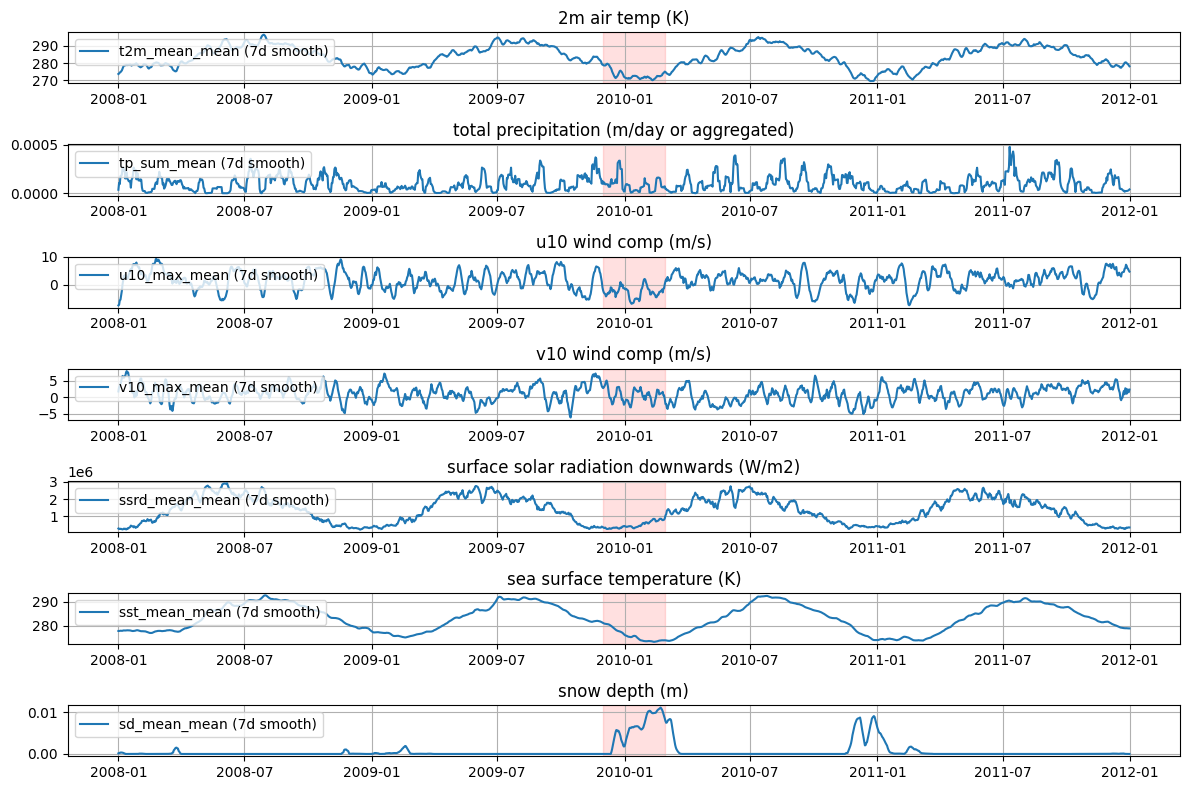

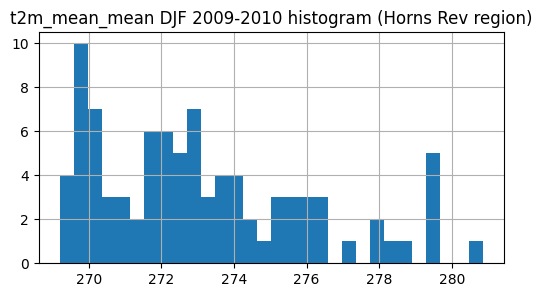

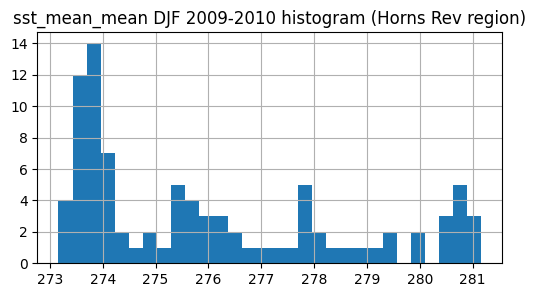

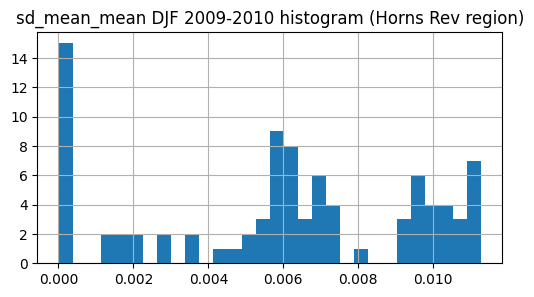

In [12]:
# Back-testing: Horns Rev (DK-001) winter 2009-2010
# Futtasd Colabban. Ellenőrizd az útvonalakat (daily file helye).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- BEÁLLÍTÁSOK ---
DAILY_PATH = "/content/cpri_outputs/dania_daily_merged.csv"
OUT_DIR = "/content/cpri_outputs/backtest_hornsrev"
os.makedirs(OUT_DIR, exist_ok=True)

# Horns Rev koordinátái (használd, ha több gridcell van; itt a régió-átlagot használjuk)
hr_lat = 55.59
hr_lon = 7.52

# Változók, amiket megnézünk
vars_to_check = [
    ("t2m_mean_mean", "2m air temp (K)"),
    ("tp_sum_mean", "total precipitation (m/day or aggregated)"),
    ("u10_max_mean", "u10 wind comp (m/s)"),
    ("v10_max_mean", "v10 wind comp (m/s)"),
    ("ssrd_mean_mean", "surface solar radiation downwards (W/m2)"),
    ("sst_mean_mean", "sea surface temperature (K)"),
    ("sd_mean_mean", "snow depth (m)")
]

# --- 1) Olvasás és előkészítés ---
df = pd.read_csv(DAILY_PATH)
print("Összes sor:", len(df))
# dátum
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date').reset_index(drop=True)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Ha a fájl két sorban adja ugyanazt a napi rekordot (dupla sorok), egyesítsük napra:
# (ha már clean a daily_merged akkor ez nem változtat)
agg_funcs = {}
for v,_ in vars_to_check:
    if v in df.columns:
        agg_funcs[v] = 'mean'
# keep date once: we will group by date
base_cols = ['date','year','month']
available = [c for c in agg_funcs.keys()]
if available:
    df_day = df.groupby('date', as_index=False).agg(agg_funcs)
    df_day['year'] = df_day['date'].dt.year
    df_day['month'] = df_day['date'].dt.month
else:
    raise ValueError("Nincsenek a várt változók a daily file-ban: ellenőrizd a neveket.")

# --- 2) Kiválasztás Horns Rev környékére ---
# Ha a daily fájl regionális (dania átlag), akkor df_day már jó. Ha rácsos, akkor filter by lat/lon nearest - ha nincs lat/lon oszlop skip.
if 'latitude' in df.columns and 'longitude' in df.columns:
    # Ha rácsos adatok vannak, válasszuk ki a legközelebbi pontot
    coords = df[['latitude','longitude']].drop_duplicates()
    coords['dist'] = np.sqrt((coords['latitude']-hr_lat)**2 + (coords['longitude']-hr_lon)**2)
    best = coords.sort_values('dist').iloc[0]
    lat_sel, lon_sel = best['latitude'], best['longitude']
    print("Használva legközelebbi rácspont:", lat_sel, lon_sel)
    # feltételezzük a df-ben van egy azonosító, csoportosítva; ha nincs, skip
    # (ha rácsos a struktúra, a usernak kell módosítania a kódot)
else:
    print("Feltételezzük, hogy a daily fájl már regionális (dania átlag).")

# --- 3) Definiáljuk a vizsgálati időszakot (DJF 2009-2010) ---
# DJF 2009/2010: Dec 2009 + Jan 2010 + Feb 2010
djf_start = pd.Timestamp("2009-12-01")
djf_end   = pd.Timestamp("2010-02-28")

# referencia idoszak (állítsd igény szerint)
ref_start = pd.Timestamp("2000-01-01")
ref_end   = pd.Timestamp("2024-12-31")  # vagy a nálad lévő végpont

# --- 4) Kiszámoljuk DJF 2009-2010 statisztikáit és referenciaértékeket ---
df_day = df_day.set_index('date')

def period_stats(series, start, end):
    seg = series.loc[start:end].dropna()
    return {
        'count': len(seg),
        'mean': float(seg.mean()) if len(seg)>0 else np.nan,
        'median': float(seg.median()) if len(seg)>0 else np.nan,
        'std': float(seg.std(ddof=1)) if len(seg)>1 else np.nan,
        'min': float(seg.min()) if len(seg)>0 else np.nan,
        'max': float(seg.max()) if len(seg)>0 else np.nan
    }

results = {}
for var, label in vars_to_check:
    if var not in df_day.columns:
        print(f"⚠ Nincs változó a fájlban: {var} (kihagyva)")
        continue

    # DJF 2009-2010
    djf_stats = period_stats(df_day[var], djf_start, djf_end)
    # referencia (összes DJF-ek a referencia-idoszakban): kötelezően összevonjuk minden év DJF-jét
    # egyszerű referencia: teljes referencia időszak napi átlag/med
    ref_stats = period_stats(df_day[var], ref_start, ref_end)

    # anomália: djf_mean - ref_mean
    anomaly_mean = np.nan
    if not np.isnan(djf_stats['mean']) and not np.isnan(ref_stats['mean']):
        anomaly_mean = djf_stats['mean'] - ref_stats['mean']

    results[var] = {
        'label': label,
        'djf': djf_stats,
        'ref': ref_stats,
        'anomaly_mean': anomaly_mean
    }

# --- 5) Kiírás és egyszerű táblázat ---
summary_rows = []
for var, info in results.items():
    row = {
        'var': var,
        'label': info['label'],
        'djf_count': info['djf']['count'],
        'djf_mean': info['djf']['mean'],
        'ref_mean': info['ref']['mean'],
        'anomaly_mean': info['anomaly_mean'],
        'djf_max': info['djf']['max'],
        'djf_min': info['djf']['min']
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values('anomaly_mean')
summary_df.to_csv(os.path.join(OUT_DIR, "hornsrev_djf2009_2010_summary.csv"), index=False)
print("✅ Summary mentve:", os.path.join(OUT_DIR, "hornsrev_djf2009_2010_summary.csv"))
print(summary_df)

# --- 6) Ábrázolás: idősort rajzolunk a vizsgált változókra (2008-2011 vizsgálat) ---
plot_start = "2008-01-01"
plot_end   = "2011-12-31"
plt.figure(figsize=(12, 8))
nplot = len(results)
for i, (var, info) in enumerate(results.items(), start=1):
    plt.subplot(nplot, 1, i)
    ser = df_day[var].loc[plot_start:plot_end]
    ser_rolling = ser.rolling(window=7, center=True, min_periods=1).mean()
    plt.plot(ser.index, ser_rolling, label=f"{var} (7d smooth)")
    # mark DJF 2009-2010
    plt.axvspan(djf_start, djf_end, color='red', alpha=0.12)
    plt.title(info['label'])
    plt.grid(True)
    plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "hornsrev_timeseries_2008_2011.png"), dpi=150)
print("✅ Timeseries ábra mentve:", os.path.join(OUT_DIR, "hornsrev_timeseries_2008_2011.png"))

# --- 7) DJF napi eloszlás histogram: snow és t2m pl. ---
for var in ['t2m_mean_mean','sst_mean_mean','sd_mean_mean']:
    if var in df_day.columns:
        plt.figure(figsize=(6,3))
        # DJF sample
        data = df_day[var].loc[djf_start:djf_end].dropna()
        plt.hist(data, bins=30)
        plt.title(f"{var} DJF 2009-2010 histogram (Horns Rev region)")
        plt.grid(True)
        outname = os.path.join(OUT_DIR, f"hist_{var}_djf2009_2010.png")
        plt.savefig(outname, dpi=150)
        print("✅ Mentve:", outname)

print("\nKész. Nézd meg az OUT_DIR tartalmát, és másold ide a summary CSV első pár sorát, vagy a képeket ha szeretnéd.")
